# Chapter - 8 Tree-Based Methods
The topics of this chapter are

- Decision trees for regression and classification
- Cost complexity pruning
- Random forests
- Boosting

Five packages are used in the examples of this chapter: ISLR, tree, randomForest, MASS, gbm.

### Regression Trees
The main idea here is to split the predictors' space in such a way that the residual sum of squares (RSS) is minimized. For example let's suppose the response variable Y depends on two predictors $X_1$ and $X_2$. We start with $X_1$ to see which is the value $x_1 = s$ that splits the predictors' space in two boxes $R_1$ and $R_2$ for which some observations fall in $R_1$ and the rest fall in $R_2$ so that  

$$RSS = \sum_{j=1}^J \sum_{x_i \in R_j} (y_i - \hat{y}_{R_j})^2$$

is minimized, and where where $\hat{y}_{R_j}$ is the mean response in the $R_j$ box. The next step is to look for the value $x_2 = s$ that results in the minimum value for RSS. We choose the predictor to split depending on which will result in the lowest RSS, in other words we split the predictor that has higher variance. We repeat again the same steps till we reach a stopping criterion such as a minimum number of observations in each box. The training phase consists of finding the splitting rules that minimize the residual sum of squares.  

### Classification Trees
The prediction, in case of a categorical predictor, is the most likely category for that predictor. We cannot use RSS to estimate the error in predicting the response for categorical predictors. As an alternative to estimate the error in making binary decisions over a categorical predictor we can use the classification error rate, that is the fraction of observations that do not belong to the most common class in a given box. As an example we consider a bag of marbles with 64 red marbles and 36 blue marbles. We can have a tree with a node "color" so that if a marble taken from the bag is red we follow the branch to the red box and if the marble is blue we follow the branch to the blue box. The classification error rate for the "color" node that we want to minimize is defined as

$$E = 1 - max(\hat p_{red}, \hat p_{blue})$$

where $\hat p_{red}$ is the proportion of red marbles and $\hat p_{blue}$ is the proportion of blue marbles

In [2]:
red_marbles <- 64
blue_marbles <- 36
p_red_box <- red_marbles / (red_marbles + blue_marbles)
p_blue_box <- blue_marbles / (red_marbles + blue_marbles)
error_rate <- 1 - max(p_red_box, p_blue_box)
error_rate

[1] 0.36

Other measures of misclassification are the Gini index

$$G = \sum_{k=1}^K \hat p_{mk} (1 - \hat p_{mk})$$

where in our example m is the node, color, and K = 2 is the number of categories, blue and red.

In [3]:
gini_index <- p_red_box * (1 - p_red_box) + p_blue_box * (1 - p_blue_box)
gini_index

[1] 0.4608

and the cross entropy

$$D = - \sum_{k=1}^K \hat p_{mk} log(\hat p_{mk})$$

In [4]:
cross_entropy <- - (p_red_box * log(p_red_box) + p_blue_box * log(p_blue_box))
cross_entropy

[1] 0.6534182

### 8.3.1 Fitting Classification Trees
In this example we want to figure out how sales of child car seats are going in different stores depending on some statistics about the population, the location, advertising and other paramenters. We use the Carseats data set from the ISLR package. 

In [6]:
library(tree)
library(ISLR)
names(Carseats); dim(Carseats)

[1] "Sales"       "CompPrice"   "Income"      "Advertising" "Population" 
 [6] "Price"       "ShelveLoc"   "Age"         "Education"   "Urban"      
[11] "US"

[1] 400  11

We add a new binary field 'High' from 'Sales' to distinguish the stores that have sold more than 8 seats. We train a tree to predict whether sales will exceed the threshold or not, using all the predictors in the Carseats data set but Sales.

In [7]:
High <- ifelse(Carseats$Sales <= 8, "No", "Yes")
Carseats <- data.frame(Carseats, High)
tree.carseats <- tree(High ~ . - Sales, data = Carseats) # fits the tree using all the predictors but Sales
summary(tree.carseats)


Classification tree:
tree(formula = High ~ . - Sales, data = Carseats)
Variables actually used in tree construction:
[1] "ShelveLoc"   "Price"       "Income"      "CompPrice"   "Population" 
[6] "Advertising" "Age"         "US"         
Number of terminal nodes:  27 
Residual mean deviance:  0.4575 = 170.7 / 373 
Misclassification error rate: 0.09 = 36 / 400 

We can see from the summary of the fit the misclassification error rate, the number of stores that have been misclassified by the rules of the tree. The misclassification error rate here has been estimated from the same data set used for the training so it might not be reliable on new data.

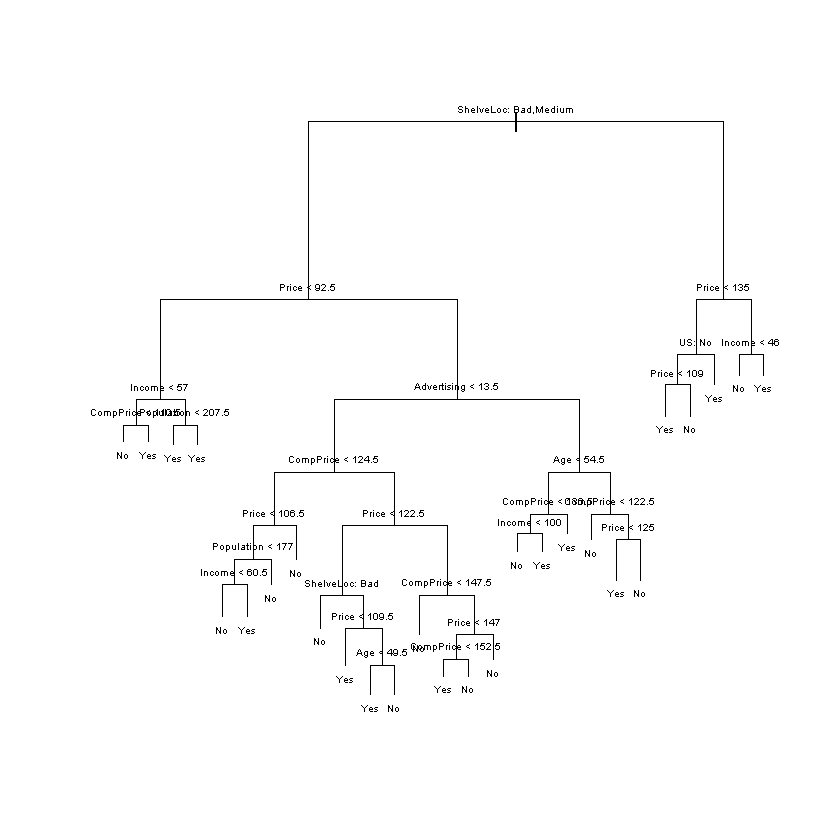

In [8]:
plot(tree.carseats)
text(tree.carseats, pretty = 0, cex= 0.5)

Now we split the data set into a training set and a test set, then we re-train the tree on the training data set, we make predictions on the test set and we find out how many predictions are misclassified.

In [9]:
set.seed(2)
train <- sample(1:nrow(Carseats), 200) # random sample of 200 rows from Carseats
Carseats.test <- Carseats[-train, ] # creates the test set removing the train set from the data set
High.test <- High[-train] # same for High field
tree.carseats <- tree(High ~ . - Sales, data = Carseats, subset = train)
tree.pred <- predict(tree.carseats, Carseats.test, type = "class") # returns the class prediction
t <- table(tree.pred, High.test)

The right predictions are in the diagonal so the misclassifications are off the diagonal. 

In [10]:
(t[1,2] + t[2,1]) / 200 

[1] 0.23

 As expected, the misclassification error rate on the test set is higher than on the trainining set that we saw before.

#### Cost complexity pruning
The tree built so far uses almost all the predictors and ends up in many leaves that may lead to overfitting the trainining set and to higher variance in the test set. It is also not very easy to understand, so we might want to remove some of the splits. We can use the same approach used in the lasso for regularization, that is, adding a term to the RSS that penalizes the number of leaves through a cost complexity parameter $k$ to be tuned using cross-validation so that the expression to be minimized becomes

$$\sum_{m=1}^{|T|} \sum_{x_i \in R_m} (y_i - \hat{y}_{R_m})^2 + k|T|$$

where |T| is the number of leaves. The function cv.tree() from the 'tree' package performs all these steps.

In [11]:
set.seed(3)
cv.carseats <- cv.tree(tree.carseats, FUN = prune.misclass)  # cross-validation with cost complexity pruning
names(cv.carseats)
cv.carseats

[1] "size"   "dev"    "k"      "method"

$size
[1] 21 19 14  9  8  5  3  2  1

$dev
[1] 74 76 81 81 75 77 78 85 81

$k
[1] -Inf  0.0  1.0  1.4  2.0  3.0  4.0  9.0 18.0

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

We plot the cross-validation error rate of the trees as function of the number of leaves and the tuning parameter k.

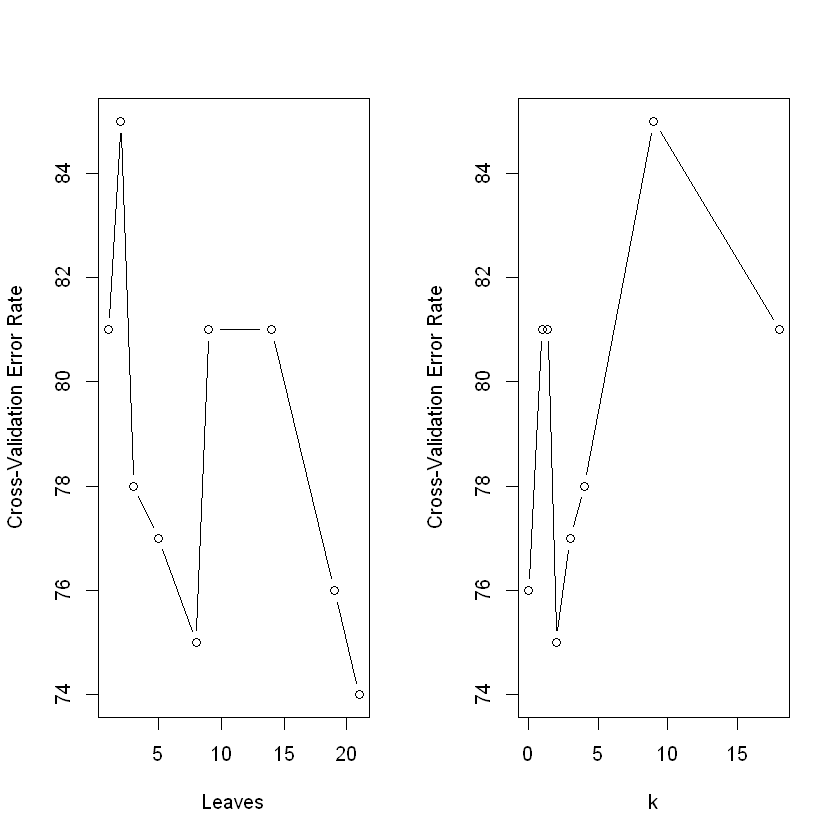

In [12]:
par(mfrow = c(1, 2))
plot(cv.carseats$size, cv.carseats$dev, type = "b", xlab = "Leaves", ylab = "Cross-Validation Error Rate") 
plot(cv.carseats$k, cv.carseats$dev, type = "b", xlab = "k", ylab = "Cross-Validation Error Rate")

We plot the tree that corresponds to the best fit from cross-validation 

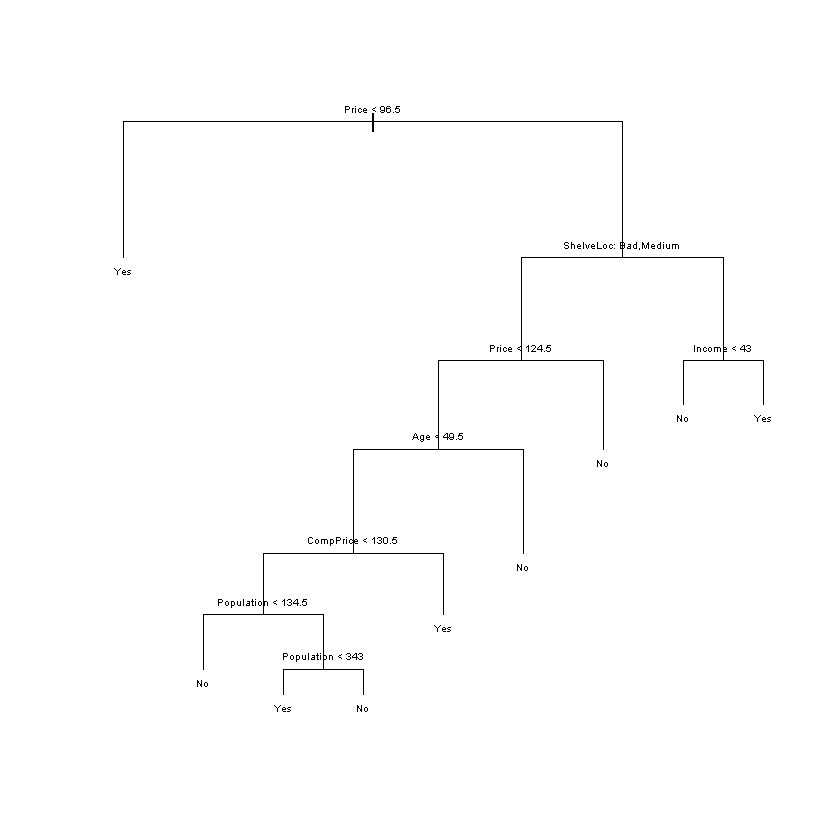

In [13]:
prune.carseats <- prune.misclass(tree.carseats, best = 9) # prunes the tree with best number of leaves
plot(prune.carseats)
text(prune.carseats, pretty = 0, cex = 0.5)

In [14]:
tree.pred <- predict(prune.carseats, Carseats.test, type = "class")
t <- table(tree.pred, High.test)
(t[1,2] + t[2,1]) / 200

[1] 0.225

The misclassification is slightly lower than without pruning and the tree is easier to interpret.

### 8.3.2 Fitting Regression Tree
As an example about fitting a regression tree we use the Boston data set, from the 'MASS' package, that is about housing values in suburbs of Boston. We train a tree using half of the observations to predict the medium value of homes (medv).

In [16]:
library(MASS)
set.seed(1)
train <- sample(1:nrow(Boston), nrow(Boston) / 2)
tree.boston <- tree(medv ~ ., data = Boston, subset = train)
summary(tree.boston)


Regression tree:
tree(formula = medv ~ ., data = Boston, subset = train)
Variables actually used in tree construction:
[1] "rm"    "lstat" "crim"  "age"  
Number of terminal nodes:  7 
Residual mean deviance:  10.38 = 2555 / 246 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-10.1800  -1.7770  -0.1775   0.0000   1.9230  16.5800 

The deviance represents the residual sum of squares (RSS)

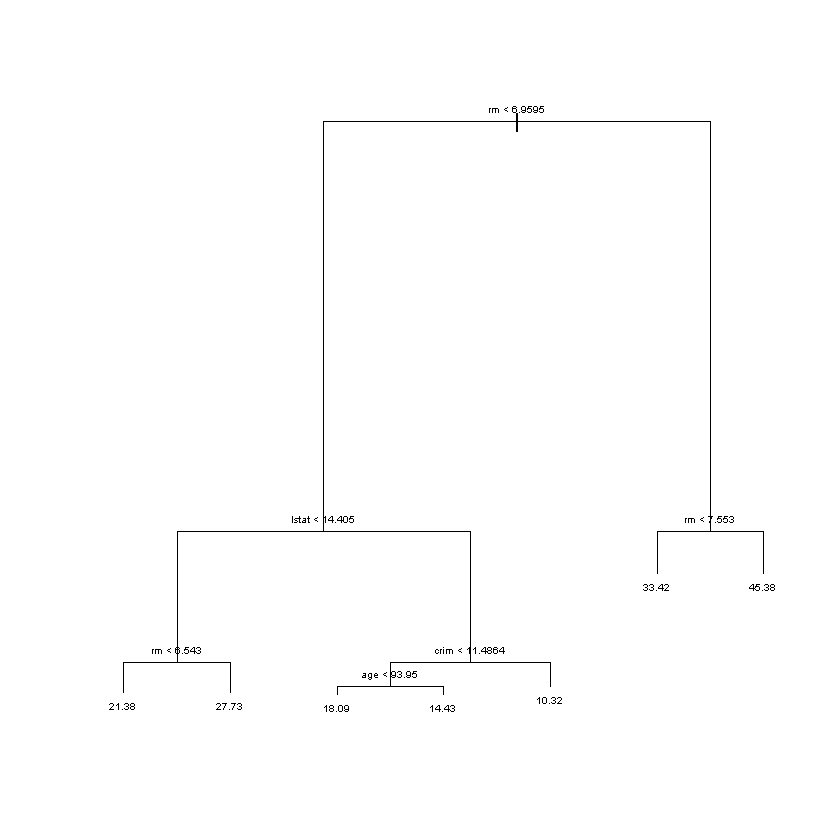

In [17]:
plot(tree.boston)
text(tree.boston, pretty = 0, cex = 0.5)

Now we use the cross-validation techniques with cost complexity pruning

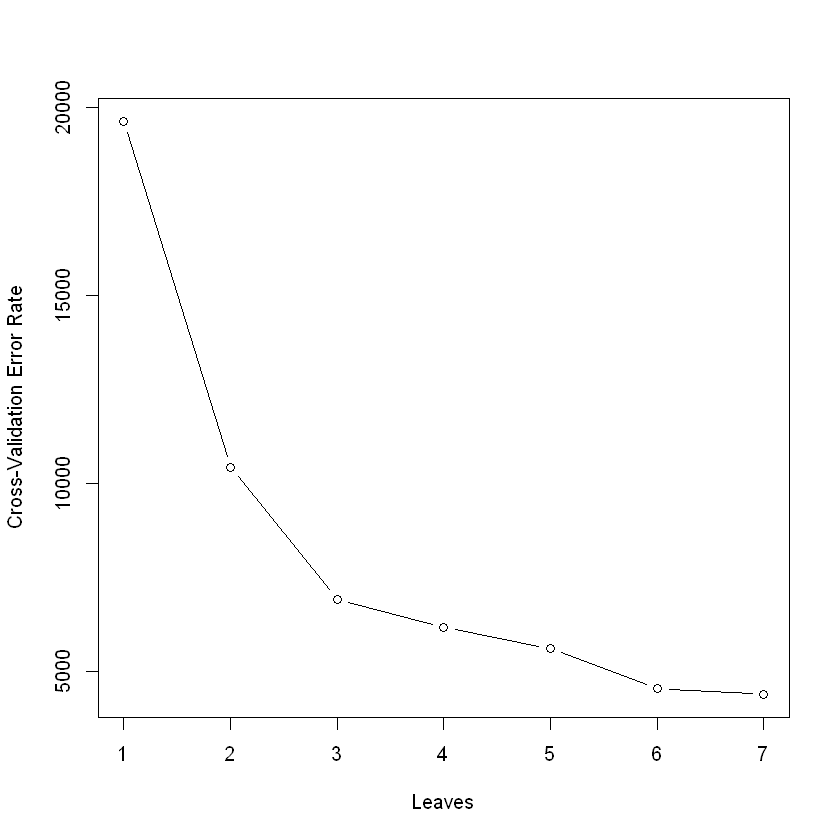

In [18]:
cv.boston <- cv.tree(tree.boston)
plot(cv.boston$size, cv.boston$dev, type = "b", xlab = "Leaves", ylab = "Cross-Validation Error Rate")

We prune the tree setting the (best) number of terminal nodes (leaves) to the one with lower cross validation error rate.

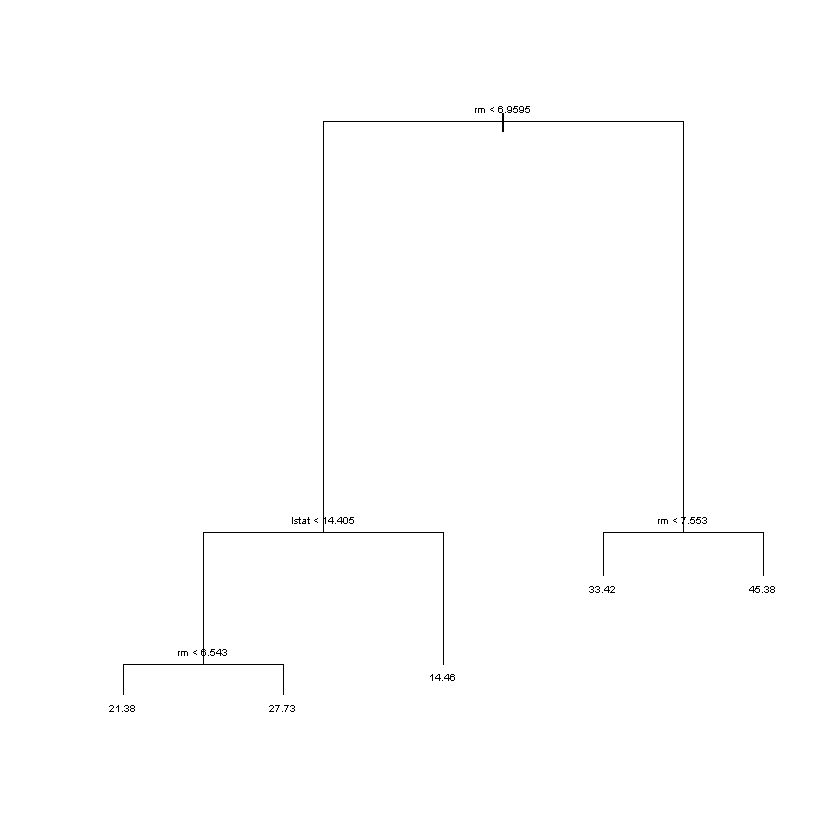

In [19]:
prune.boston <- prune.tree(tree.boston, best = 5)
plot(prune.boston)
text(prune.boston, pretty = 0, cex = 0.5)

We can use the un-pruned tree to make prediction on the test set and compute the mean squared error.

[1] 35.28688

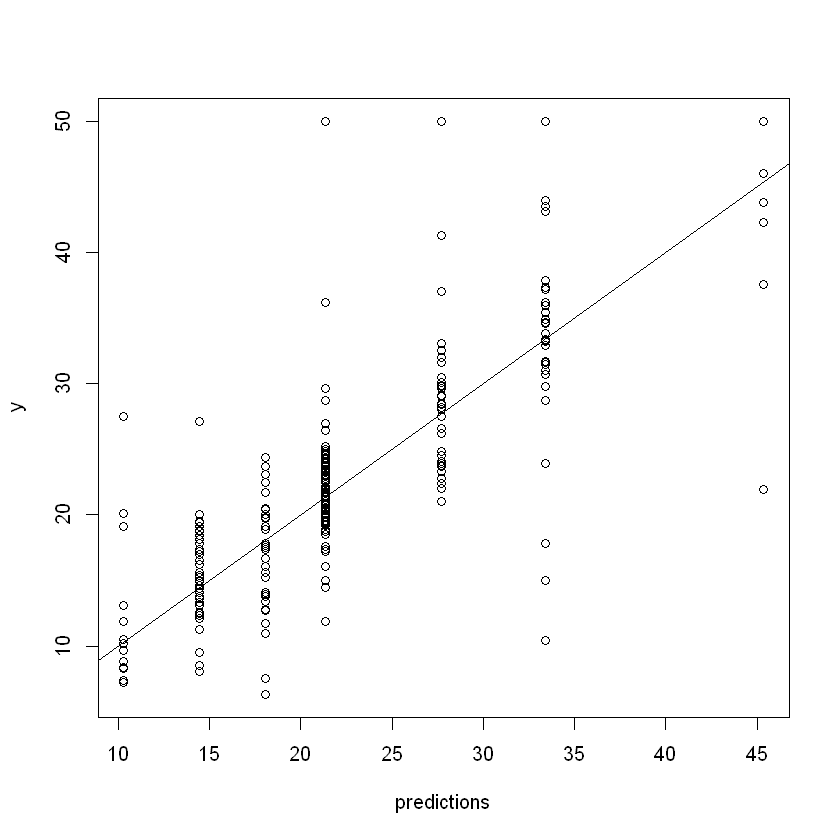

In [20]:
yhat <- predict(tree.boston, newdata = Boston[-train, ]) # make predictions on the test set using the un-pruned fit
boston.test <- Boston[-train, "medv"] # select the field "medv" of the test set
plot(yhat, boston.test, xlab = "predictions", ylab = "y")
abline(0, 1)
mean((yhat - boston.test)^2) # mean squared error on the test set

### 8.3.3 Bagging and Random Forests
A general-purpose technique to reduce variance is to averaging the responses from many different trees. More precisely the idea is to use the bootstrap to randomly sample new data sets from the original one, fit a model with each of the sample and then use all the models to estimate the average response.   

$$y_{avg} = \frac{1}{B} \sum_{b=1}^B \hat f^b(x)$$

where B is the number of bootstrap samples taken from the original data set and $\hat f^b(x)$ is the prediction of the model fit using the $b^{th}$ bootstrap sample.

As an example we use again the Boston data set and the randomForest package to do the bagging. 

In [28]:
library(randomForest)
set.seed(1)
bag.boston <- randomForest(medv ~ ., data = Boston, subset = train, mtry = 13, importance = TRUE) # considers all 13 predictors
bag.boston


Call:
 randomForest(formula = medv ~ ., data = Boston, mtry = 13, importance = TRUE,      subset = train) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 13

          Mean of squared residuals: 11.39601
                    % Var explained: 85.17

[1] 23.59273

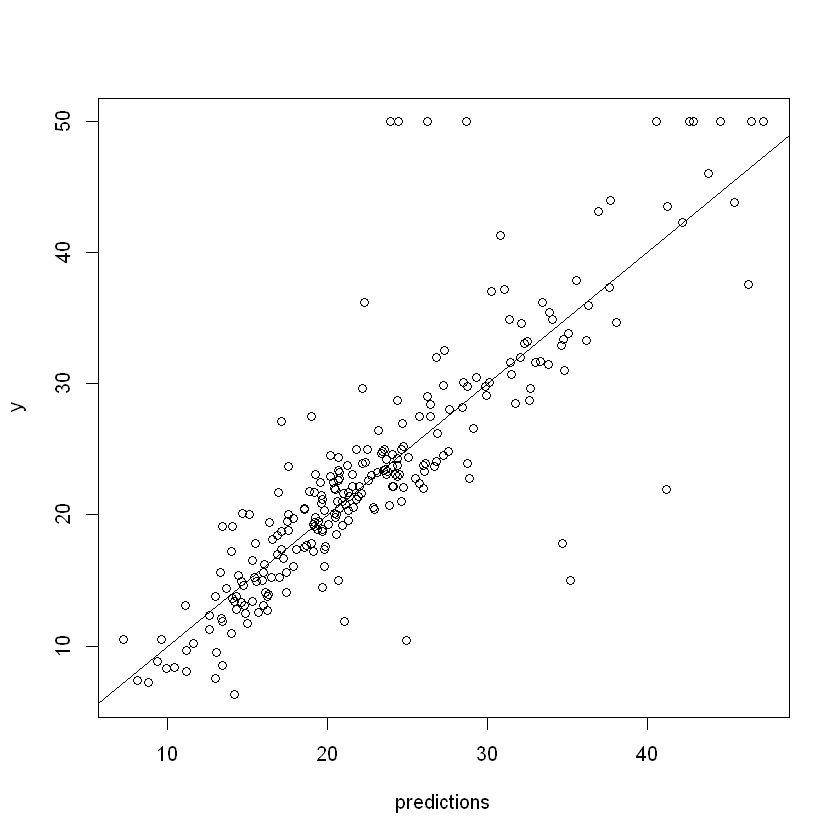

In [22]:
yhat.bag <- predict(bag.boston, newdata = Boston[-train, ])
plot(yhat.bag, boston.test, xlab = "predictions", ylab = "y")
abline(0, 1)
mean((yhat.bag - boston.test)^2) # mean squared error on the test set

As we can see, the mean squared error on the test set is significantly lower than with a single tree, and the predictions are very well aligned with the observations.

Bagging is a special case of Random forest in which all the $p$ predictors are used. We compute now the mean squared error using random forest, that is setting the number of predictors $m$ to use for each tree to a value below $p$. 

In [23]:
set.seed(1)
rf.boston <- randomForest(medv ~ ., data = Boston, subset = train, mtry = 6, importance = TRUE) # uses 6 predictors 
yhat.rf <- predict(rf.boston, newdata = Boston[-train, ])
mean((yhat.rf -boston.test)^2)

[1] 19.62021

Random forest is significantly better than bagging. Probably reducing the number of predictors removes some variance due to correlations.

We can see which predictors are most relevant for the accuracy, those that when they are removed from the tree, the MSE increases according to the value in the list.

In [24]:
importance(rf.boston, type = 1) # importance by mean squared error decrease

,%IncMSE
crim,16.697017
zn,3.625784
indus,4.968621
chas,1.061432
nox,13.518179
rm,32.343305
age,13.272498
dis,9.032477
rad,2.878434
tax,9.118801


### 8.3.4 Boosting
Like random forests, boosting consists of combining a large number of decision trees, fit using random bootstrap samples of the original data set, but the trees are fit using the residuals and fine tuned through a regularization parameter.

,var,rel.inf
rm,rm,43.74026120
lstat,lstat,33.20732994
dis,dis,4.73173269
crim,crim,3.98025407
age,age,2.88223796
nox,nox,2.87429627
black,black,2.70379743
ptratio,ptratio,2.50586171
tax,tax,1.67262086
indus,indus,0.85966837


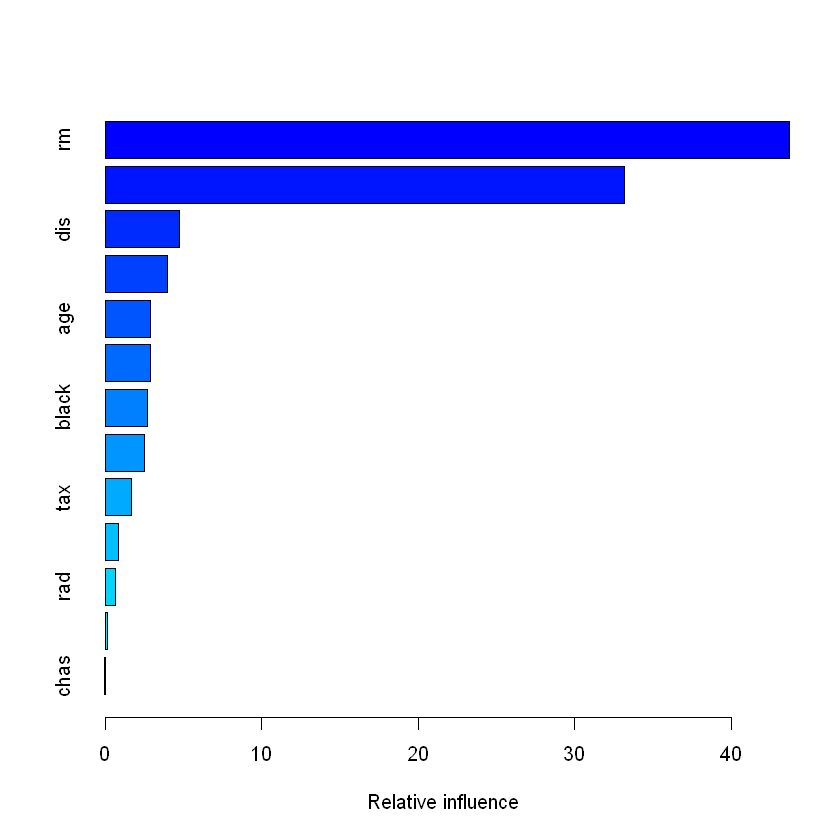

In [26]:
library(gbm)
set.seed(1)
boost.boston <- gbm(medv ~ ., data = Boston[train, ], distribution = "gaussian", n.trees = 5000, 
                    interaction.depth = 4, shrinkage = 0.02 )
summary(boost.boston)

We compute the mean squared error on the test set

In [27]:
yhat.boost <- predict(boost.boston, newdata = Boston[-train, ], n.trees = 5000)
mean((yhat.boost - boston.test)^2)

[1] 17.53748

The accuracy can be better than using random forests if we set the shrinkage parameter carefully.